In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import string
from re import search

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import pickle

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Подготовка данных
## 1.1 Добавление целевого вектора

In [3]:
df =  pd.read_csv('train.csv')

In [4]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
df['target'] = df[['toxic','severe_toxic','obscene','threat', 'insult', 'identity_hate']].max(axis=1)
df.drop(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)

In [7]:
df.head(10)

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [8]:
toxic_ratio = df.target.sum() / df.shape[0]
print(f'toxic_ratio comments: {toxic_ratio * 100:.2f}%')

toxic_ratio comments: 10.17%


## 1.2 Лематизация комментариев

In [9]:
# Определенте стоп слов
stop_words = set(stopwords.words('english'))
stop_words.update(["i'm", "'s", "'d", "'m", "'ll"])
stop_words.remove('not')

#Определение словаря знаков препинания 
punctuation = string.punctuation 

#Определение функций ламматизатора
wordnet_lemmatizer = WordNetLemmatizer()

In [10]:
#Функцция лемматизаций
def tokenizer(text):
    tokens = ['not' if word == "n't" else word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    # Фильтр знаков припенания и стоп-слов
    tokens = list(filter(lambda t: t not in punctuation and t.lower() not in stop_words, tokens)) 
    filtered_tokens = [token.replace("'", '') for token in tokens if search('[a-zA-Z]', token)]
    # Лемматизаци токенов
    filtered_tokens = list(map(lambda token: wordnet_lemmatizer.lemmatize(token if token.isupper() else token.lower()), filtered_tokens)) 
    # Фильтр знаков припенания
    filtered_tokens = list(filter(lambda t: t not in punctuation, filtered_tokens)) 
    return ' '.join(filtered_tokens)

In [11]:
%%time
# Применение лематизации тексту
df['clean_comment_text'] = df['comment_text'].map(tokenizer) 

CPU times: user 3min 8s, sys: 834 ms, total: 3min 9s
Wall time: 3min 16s


In [12]:
df.head(10)

,comment_text,target,clean_comment_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,daww match background colour seemingly stuck t...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really not trying edit war guy constan...
3,"""\nMore\nI can't make any real suggestions on ...",0,ca not make real suggestion improvement wonder...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER PISS AROUND WORK
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article reverted pl...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway not inten...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


## 1.3 Разбиение выборки на тренировачную и валидационную

In [13]:
df_train, df_validate = train_test_split(df, test_size=0.2, shuffle=True)

In [14]:
print(df_train.shape, df_validate.shape)

(127656, 3) (31915, 3)


## 1.4 Подготовка к обучению

In [15]:
vectorizer = TfidfVectorizer(stop_words=stop_words)

In [16]:
def tf_idf(data, fit=0):
    X = data['clean_comment_text'].values.astype('U')
    if fit:
        X = vectorizer.fit_transform(X)
        pickle.dump(vectorizer, open("feature.pkl", "wb"))
    else:
        X = vectorizer.transform(X)
    
    Y = data['target']
    return X, Y

In [17]:
train_X, train_Y = tf_idf(df_train, 1)

# 2. Обучение модели
## 2.1 Метрики качества

In [19]:
def print_f1_score(f1_score, method):
    print(f'f1 for {method} = {f1_score:.3f}')

In [20]:
def print_ROC_curve(roc_score, method):
    def ROC_curve(roc_score, color):
        fpr, tpr, thresholds = roc_score
        plt.title("ROC-curve")
        plt.xlabel("fpr")
        plt.ylabel("tpr")

        plt.plot(fpr, tpr, color=color)

        return auc(fpr, tpr)


    print(f"ROC_AUC for {method} = {ROC_curve(roc_score, 'orange'):.3f}")

    plt.legend(method, loc='lower right')

    plt.grid()
    plt.show()

In [21]:
def print_PR_curve(pr_score, method):
    def PR_curve(pr_score, color):
        precision, recall, thresholds = pr_score

        plt.title("PR-curve")
        plt.xlabel("recall")
        plt.ylabel("precision")

        plt.plot(recall, precision, color=color)

        return auc(recall, precision)


    print(f"PR_AUC for {method} = {PR_curve(pr_score, 'orange'):.3f}")

    plt.legend(method, loc='lower right')

    plt.grid()
    plt.show()

## 2.2 Логистическая регрессия

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
%%time
model = LogisticRegression(max_iter=1000, random_state=242, solver='saga')
model.fit(train_X, train_Y)

validate_predict_class = model.predict(validate_X)
validate_predict_estimates = model.predict_proba(validate_X)[:, 1]

f1_score_val = f1_score(validate_Y, validate_predict_class)
roc_score = roc_curve(validate_Y, validate_predict_estimates)
pr_score = precision_recall_curve(validate_Y, validate_predict_estimates)

CPU times: user 3.1 s, sys: 4.87 ms, total: 3.1 s
Wall time: 3.09 s


In [24]:
print_f1_score(f1_score_val, 'Logistic Regression')

f1 for Logistic Regression = 0.727


ROC_AUC for Logistic Regression = 0.968


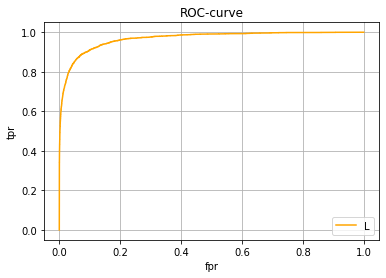

In [25]:
print_ROC_curve(roc_score, 'Logistic Regression')

PR_AUC for Logistic Regression = 0.862


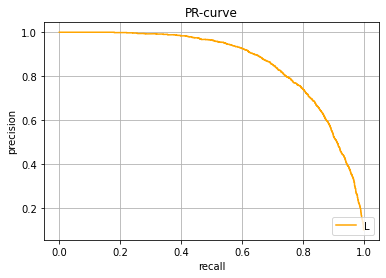

In [26]:
print_PR_curve(pr_score, 'Logistic Regression')

## 2.3 Решающее дерево

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
%%time
model = DecisionTreeClassifier(random_state=242, max_depth=100)
model.fit(train_X, train_Y)

validate_predict_class = model.predict(validate_X)
validate_predict_estimates = model.predict_proba(validate_X)[:, 1]

f1_score_val = f1_score(validate_Y, validate_predict_class)
roc_score = roc_curve(validate_Y, validate_predict_estimates)
pr_score = precision_recall_curve(validate_Y, validate_predict_estimates)

CPU times: user 1min 15s, sys: 71 ms, total: 1min 15s
Wall time: 1min 15s


In [29]:
print_f1_score(f1_score_val, 'Decision Tree')

f1 for Decision Tree = 0.714


ROC_AUC for Decision Tree = 0.789


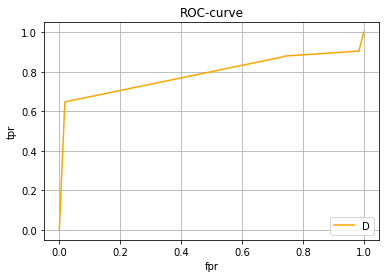

In [30]:
print_ROC_curve(roc_score, 'Decision Tree')

PR_AUC for Decision Tree = 0.699


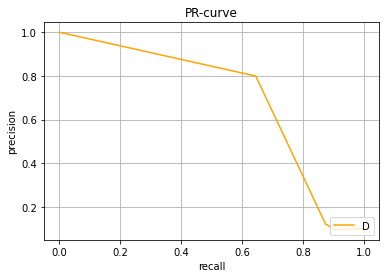

In [31]:
print_PR_curve(pr_score, 'Decision Tree')

## 2.4 Метод опорных векторов

In [32]:
from sklearn.svm import LinearSVC

In [33]:
%%time
model = LinearSVC(random_state=242, dual=False, max_iter=2000)
model.fit(train_X, train_Y)

validate_predict_class = model.predict(validate_X)

f1_score_val = f1_score(validate_Y, validate_predict_class)
roc_score = roc_curve(validate_Y, validate_predict_class)
pr_score = precision_recall_curve(validate_Y, validate_predict_class)

CPU times: user 3.31 s, sys: 2.19 s, total: 5.5 s
Wall time: 2.91 s


In [34]:
print_f1_score(f1_score_val, 'Linear SVC')

f1 for Linear SVC = 0.776


ROC_AUC for Linear SVC = 0.841


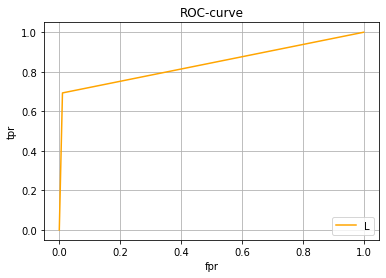

In [35]:
print_ROC_curve(roc_score, 'Linear SVC')

PR_AUC for Linear SVC = 0.804


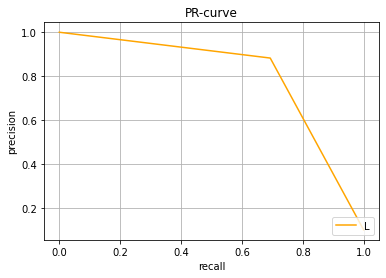

In [36]:
print_PR_curve(pr_score, 'Linear SVC')

# 3. Сохранение лучшей модели

In [37]:
%%time
best_model = LogisticRegression(max_iter=1000, random_state=242, solver='saga')
best_model.fit(train_X, train_Y)

CPU times: user 2.72 s, sys: 7.99 ms, total: 2.73 s
Wall time: 2.73 s


In [38]:
pickle.dump(best_model, open('best_model.pickle', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pickle', 'wb'))